In [1]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Create the novel variables

In [3]:
n =  27827 #novel number
t = 'kama_sutra'#novel name
s = 1 #how many rows to skip

* Get the novels from Gutenberg.
* Strip them of unwanted information.
* Tokenize the text into sentences.

In [4]:
novel = strip_headers(load_etext(n))
novel = novel.replace('\n', ' ')
novel= TextBlob(novel)
novel_sentences = novel.sentences
novel_title = t

Write the sentences to a csv file. 
-There is a bug I haven't figure out yet that requires me to write to csv twice to avoid errors.

In [5]:
for l in range(2):
    novelWriter = csv.writer(open('data/novel_'+novel_title+'.csv', 'w'), delimiter=',')
    for sentence in novel_sentences:
        novelWriter.writerow([sentence])

Read in the csv file to pandas

In [6]:
df_novel = pd.read_csv('data/novel_'+novel_title+'.csv', skiprows = s, header=None)

In [8]:
df_novel.head()

,0
0,Printer errors have been changed and are liste...
1,THE KAMA SUTRA OF VATSYAYANA.
2,TRANSLATED FROM THE SANSCRIT.
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC..."
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...


Create the wrd_length and total_char columns.

In [9]:
wrd_length = []
total_char = []
def wrd_char_counts(sentence):
    total_chars = 0
    wrd_counts = []
    for word in sentence:
        char_count = len(word)
        wrd_counts.append(char_count)
        total_chars += char_count
    total_char.append(total_chars)
    wrd_length.append(wrd_counts)

In [10]:
for l in df_novel[0]:
    sent = TextBlob(l)
    wrd_char_counts(sent.words)

In [11]:
df_novel['wrd_length'] = wrd_length
df_novel['total_char'] = total_char

In [12]:
df_novel.head()

,0,wrd_length,total_char
0,Printer errors have been changed and are liste...,"[7, 6, 4, 4, 7, 3, 3, 6, 2, 3, 3]",48
1,THE KAMA SUTRA OF VATSYAYANA.,"[3, 4, 5, 2, 10]",24
2,TRANSLATED FROM THE SANSCRIT.,"[10, 4, 3, 8]",25
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC...","[2, 5, 5, 4, 7, 12, 3, 10, 7]",55
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...,"[7, 9, 12, 3, 3, 4, 7, 7, 2, 6, 3, 7, 3, 3, 7,...",216


Create syllable count column

In [13]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [14]:
syl = []
for l in df_novel[0]:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)  

In [15]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [16]:
df_novel['syl_count'] = syl_count_arr

In [17]:
df_novel.head()

,0,wrd_length,total_char,syl_count
0,Printer errors have been changed and are liste...,"[7, 6, 4, 4, 7, 3, 3, 6, 2, 3, 3]",48,"[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,THE KAMA SUTRA OF VATSYAYANA.,"[3, 4, 5, 2, 10]",24,"[1, 2, 2, 1, 5]"
2,TRANSLATED FROM THE SANSCRIT.,"[10, 4, 3, 8]",25,"[2, 1, 1, 2]"
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC...","[2, 5, 5, 4, 7, 12, 3, 10, 7]",55,"[1, 2, 1, 1, 2, 4, 1, 3, 2]"
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...,"[7, 9, 12, 3, 3, 4, 7, 7, 2, 6, 3, 7, 3, 3, 7,...",216,"[2, 4, 1, 1, 1, 2, 2, 4, 1, 2, 1, 2, 1, 1, 2, ..."


In [18]:
#If novel has a lot of numbers for chapter headings.
#d = df_novel[df_novel['total_char']<=2]

Create syllable sum column

In [19]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [20]:
df_novel['syl_sum'] = syl_sum

Create sentiment column

In [21]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [22]:
df_novel['sentiment'] = df_novel[0].apply(detect_sentiment)

Create cluster dataframe - remove columns that can't be used

In [23]:
df_cluster = df_novel.drop('wrd_length', 1)

In [24]:
df_cluster = df_cluster.drop('syl_count', 1)

In [25]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,Printer errors have been changed and are liste...,48,13,0.00
1,THE KAMA SUTRA OF VATSYAYANA.,24,11,0.00
2,TRANSLATED FROM THE SANSCRIT.,25,6,0.00
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC...",55,17,0.00
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...,216,70,-0.05


Create 20 clusters on scaled data

In [26]:
X = df_cluster.drop(0, axis=1)

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [28]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [29]:
df_cluster_20 = df_cluster.copy()

In [30]:
df_cluster_20['cluster'] = km.labels_

In [31]:
df_cluster_20.head()

,0,total_char,syl_sum,sentiment,cluster
0,Printer errors have been changed and are liste...,48,13,0.00,11
1,THE KAMA SUTRA OF VATSYAYANA.,24,11,0.00,11
2,TRANSLATED FROM THE SANSCRIT.,25,6,0.00,1
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC...",55,17,0.00,11
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...,216,70,-0.05,7


In [32]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,Printer errors have been changed and are liste...,48,13,0.00
1,THE KAMA SUTRA OF VATSYAYANA.,24,11,0.00
2,TRANSLATED FROM THE SANSCRIT.,25,6,0.00
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC...",55,17,0.00
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...,216,70,-0.05


In [33]:
df_cluster_20.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,123.880503,40.163522,0.277048
1,6.328106,1.720145,0.000510
2,3772.000000,1228.000000,0.044070
3,167.933702,53.790055,0.155242
4,50.615385,16.153846,-0.685623
5,143.805970,46.507463,-0.024567
6,75.000000,24.233333,0.793056
7,221.913043,71.530435,-0.034613
8,1479.000000,457.000000,-0.037183


In [34]:
centers = df_cluster_20.groupby('cluster').mean()

Create Scatter plot 

In [35]:
colors = np.array(['#0000ff', '#ff00ff', '#39b54a', '#ff0000', '#ffff00', '#000080', '#ff99ff', '#88d392', '#bf0000', '#b4ff33', '#0000bf', '#800080','#1d5b25', '#4d226d', '#2b6855', '#128ab2', '#6666ff', '#a381bd', '#333333','#a0d0e0'])

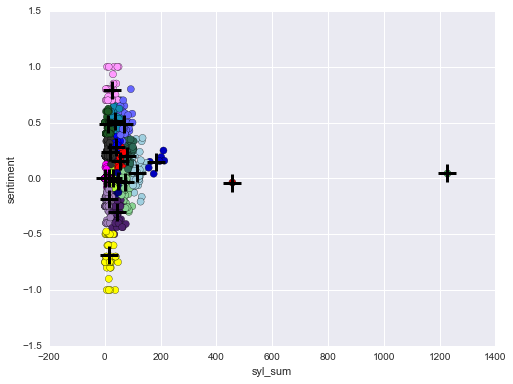

In [36]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df_cluster_20.syl_sum, df_cluster_20.sentiment, c=colors[df_cluster_20.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

Add cluster_20 to original dataframe

In [37]:
df_novel['cluster_20'] = df_cluster_20['cluster']

In [38]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20
0,Printer errors have been changed and are liste...,"[7, 6, 4, 4, 7, 3, 3, 6, 2, 3, 3]",48,"[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]",13,0.00,11
1,THE KAMA SUTRA OF VATSYAYANA.,"[3, 4, 5, 2, 10]",24,"[1, 2, 2, 1, 5]",11,0.00,11
2,TRANSLATED FROM THE SANSCRIT.,"[10, 4, 3, 8]",25,"[2, 1, 1, 2]",6,0.00,1
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC...","[2, 5, 5, 4, 7, 12, 3, 10, 7]",55,"[1, 2, 1, 1, 2, 4, 1, 3, 2]",17,0.00,11
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...,"[7, 9, 12, 3, 3, 4, 7, 7, 2, 6, 3, 7, 3, 3, 7,...",216,"[2, 4, 1, 1, 1, 2, 2, 4, 1, 2, 1, 2, 1, 1, 2, ...",70,-0.05,7


Create 3 clusters

In [39]:
df_cluster_3 = df_cluster.copy()

In [40]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment
0,Printer errors have been changed and are liste...,48,13,0.00
1,THE KAMA SUTRA OF VATSYAYANA.,24,11,0.00
2,TRANSLATED FROM THE SANSCRIT.,25,6,0.00
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC...",55,17,0.00
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...,216,70,-0.05


In [41]:
X = df_cluster_3.drop(0, axis=1)

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [43]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [44]:
df_cluster_3['cluster'] = km.labels_

In [45]:
df_cluster_3.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,43.395087,13.772262,-0.026367
1,162.805395,52.661850,0.241183
2,3772.000000,1228.000000,0.044070


In [46]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment,cluster
0,Printer errors have been changed and are liste...,48,13,0.00,0
1,THE KAMA SUTRA OF VATSYAYANA.,24,11,0.00,0
2,TRANSLATED FROM THE SANSCRIT.,25,6,0.00,0
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC...",55,17,0.00,0
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...,216,70,-0.05,1


Add cludter_3 to original dataframe

In [47]:
df_novel['cluster_3_syl'] = df_cluster_3['cluster']

In [48]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl
0,Printer errors have been changed and are liste...,"[7, 6, 4, 4, 7, 3, 3, 6, 2, 3, 3]",48,"[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]",13,0.00,11,0
1,THE KAMA SUTRA OF VATSYAYANA.,"[3, 4, 5, 2, 10]",24,"[1, 2, 2, 1, 5]",11,0.00,11,0
2,TRANSLATED FROM THE SANSCRIT.,"[10, 4, 3, 8]",25,"[2, 1, 1, 2]",6,0.00,1,0
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC...","[2, 5, 5, 4, 7, 12, 3, 10, 7]",55,"[1, 2, 1, 1, 2, 4, 1, 3, 2]",17,0.00,11,0
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...,"[7, 9, 12, 3, 3, 4, 7, 7, 2, 6, 3, 7, 3, 3, 7,...",216,"[2, 4, 1, 1, 1, 2, 2, 4, 1, 2, 1, 2, 1, 1, 2, ...",70,-0.05,7,1


Create 3 Clusters with no syl_sum

In [49]:
df_cluster_3no_syl = df_cluster.copy()

In [50]:
df_cluster_3no_syl = df_cluster.drop('syl_sum', 1)

In [51]:
X = df_cluster_3no_syl.drop(0, axis=1)

In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [53]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [54]:
df_cluster_3no_syl['cluster'] = km.labels_

In [55]:
df_cluster_3no_syl.head()

,0,total_char,sentiment,cluster
0,Printer errors have been changed and are liste...,48,0.00,1
1,THE KAMA SUTRA OF VATSYAYANA.,24,0.00,1
2,TRANSLATED FROM THE SANSCRIT.,25,0.00,1
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC...",55,0.00,1
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...,216,-0.05,1


In [56]:
df_cluster_3no_syl.groupby('cluster').mean()

,total_char,sentiment
cluster,,
0,151.141583,0.300662
1,56.425776,-0.033827
2,3772.000000,0.044070


Add cluster_3no_syl to original dataframe

In [57]:
df_novel['cluster_3no_syl'] = df_cluster_3no_syl['cluster']

In [58]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl
0,Printer errors have been changed and are liste...,"[7, 6, 4, 4, 7, 3, 3, 6, 2, 3, 3]",48,"[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]",13,0.00,11,0,1
1,THE KAMA SUTRA OF VATSYAYANA.,"[3, 4, 5, 2, 10]",24,"[1, 2, 2, 1, 5]",11,0.00,11,0,1
2,TRANSLATED FROM THE SANSCRIT.,"[10, 4, 3, 8]",25,"[2, 1, 1, 2]",6,0.00,1,0,1
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC...","[2, 5, 5, 4, 7, 12, 3, 10, 7]",55,"[1, 2, 1, 1, 2, 4, 1, 3, 2]",17,0.00,11,0,1
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...,"[7, 9, 12, 3, 3, 4, 7, 7, 2, 6, 3, 7, 3, 3, 7,...",216,"[2, 4, 1, 1, 1, 2, 2, 4, 1, 2, 1, 2, 1, 1, 2, ...",70,-0.05,7,1,1


Create 5 Clusters

In [59]:
df_cluster_5 = df_cluster.copy()

In [60]:
df_cluster_5.head()

,0,total_char,syl_sum,sentiment
0,Printer errors have been changed and are liste...,48,13,0.00
1,THE KAMA SUTRA OF VATSYAYANA.,24,11,0.00
2,TRANSLATED FROM THE SANSCRIT.,25,6,0.00
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC...",55,17,0.00
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...,216,70,-0.05


In [61]:
X = df_cluster_5.drop(0, axis=1)

In [62]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [63]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [64]:
df_cluster_5['cluster'] = km.labels_

In [65]:
df_cluster_5.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,94.843882,30.635021,0.423978
1,23.603825,7.383880,-0.024503
2,128.541393,41.289093,-0.009531
3,3772.000000,1228.000000,0.044070
4,260.935154,84.716724,0.139887


Add cluster_5 to original dataframe

In [66]:
df_novel['cluster_5'] = df_cluster_5['cluster']

In [67]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
0,Printer errors have been changed and are liste...,"[7, 6, 4, 4, 7, 3, 3, 6, 2, 3, 3]",48,"[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]",13,0.00,11,0,1,1
1,THE KAMA SUTRA OF VATSYAYANA.,"[3, 4, 5, 2, 10]",24,"[1, 2, 2, 1, 5]",11,0.00,11,0,1,1
2,TRANSLATED FROM THE SANSCRIT.,"[10, 4, 3, 8]",25,"[2, 1, 1, 2]",6,0.00,1,0,1,1
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC...","[2, 5, 5, 4, 7, 12, 3, 10, 7]",55,"[1, 2, 1, 1, 2, 4, 1, 3, 2]",17,0.00,11,0,1,1
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...,"[7, 9, 12, 3, 3, 4, 7, 7, 2, 6, 3, 7, 3, 3, 7,...",216,"[2, 4, 1, 1, 1, 2, 2, 4, 1, 2, 1, 2, 1, 1, 2, ...",70,-0.05,7,1,1,4


Write files to csv

In [68]:
df_novel.to_csv('data/novel_'+novel_title+'.csv', index=False)

In [69]:
df_test = pd.read_csv('data/novel_'+novel_title+'.csv')

In [70]:
df_test.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
0,Printer errors have been changed and are liste...,"[7, 6, 4, 4, 7, 3, 3, 6, 2, 3, 3]",48,[2 2 1 1 1 1 1 1 1 1 1],13,0.00,11,0,1,1
1,THE KAMA SUTRA OF VATSYAYANA.,"[3, 4, 5, 2, 10]",24,[1 2 2 1 5],11,0.00,11,0,1,1
2,TRANSLATED FROM THE SANSCRIT.,"[10, 4, 3, 8]",25,[2 1 1 2],6,0.00,1,0,1,1
3,"IN SEVEN PARTS, WITH PREFACE, INTRODUC...","[2, 5, 5, 4, 7, 12, 3, 10, 7]",55,[1 2 1 1 2 4 1 3 2],17,0.00,11,0,1,1
4,Reprint: _Cosmopoli: MDCCCLXXXIII: for the...,"[7, 9, 12, 3, 3, 4, 7, 7, 2, 6, 3, 7, 3, 3, 7,...",216,[2 4 1 1 1 2 2 4 1 2 1 2 1 1 2 4 2 3 1 1 1 2 1...,70,-0.05,7,1,1,4


Find ideal amount of clusters for novel

Find Sentiment Pattern 

20 pieces

In [71]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
2988,"Page 168: ""incanations mentioned"" changed to ""...","[4, 3, 11, 9, 7, 2, 12, 9]",57,"[1, 0, 4, 2, 1, 1, 4, 2]",15,0.0,11,0,1,1
2989,"Page 171: ""trapa bisqinosa"" changed to ""trapa ...","[4, 3, 5, 9, 7, 2, 5, 9]",44,"[1, 0, 2, 4, 1, 1, 2, 4]",15,0.0,11,0,1,1
2990,"Page 173: ""he of the same size"" changed to ""be...","[4, 3, 2, 2, 3, 4, 4, 7, 2, 2, 2, 3, 4, 4]",46,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",13,0.0,11,0,1,1
2991,"Page 175: ""seeds of the pomegranite"" changed t...","[4, 3, 5, 2, 3, 11, 7, 2, 5, 2, 3, 11]",58,"[1, 0, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4]",17,0.0,11,0,1,1
2992,"Page 179: ""ready deliverence"" changed to ""read...","[4, 3, 5, 11, 7, 2, 5, 11]",48,"[1, 0, 3, 4, 1, 1, 3, 4]",17,0.2,18,0,0,1


In [72]:
df_novel['total_char'].sum()

257558

In [73]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/20) - (.06 * (int(len(df_novel) - 1)))
# or figure out some better code. 
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w <= ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)     

In [74]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1      

df_novel['total_char'][0:119]
df_novel['total_char'][119:315]
df_novel['total_char'][315:525]
df_novel['total_char'][525:720]
df_novel['total_char'][720:845]
df_novel['total_char'][845:1013]
df_novel['total_char'][1013:1143]
df_novel['total_char'][1143:1305]
df_novel['total_char'][1305:1417]
df_novel['total_char'][1417:1487]
df_novel['total_char'][1487:1597]
df_novel['total_char'][1597:1752]
df_novel['total_char'][1752:1975]
df_novel['total_char'][1975:2080]
df_novel['total_char'][2080:2191]
df_novel['total_char'][2191:2286]
df_novel['total_char'][2286:2498]
df_novel['total_char'][2498:2613]
df_novel['total_char'][2613:2759]
df_novel['total_char'][2759:2942]


In [75]:
twenty_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    twenty_piece_char.append(mn)
    print mn
    st +=1   

0
119
0.118018591455
119
315
0.0549034449381
315
525
0.0109748891981
525
720
0.0604009797081
720
845
0.107352804233
845
1013
0.0732556890035
1013
1143
0.113125016437
1143
1305
0.084102905472
1305
1417
0.0940695566421
1417
1487
0.119165103415
1487
1597
0.0796829906205
1597
1752
0.0718662198017
1752
1975
0.0539014046077
1975
2080
0.070116261252
2080
2191
0.0994231410898
2191
2286
0.0852771220132
2286
2498
0.042617300589
2498
2613
0.0299036942181
2613
2759
0.0328021593133
2759
2942
0.0550506016449


In [76]:
n = np.array(n)
twenty_piece_char = np.array(twenty_piece_char)
print twenty_piece_char

[ 0.11801859  0.05490344  0.01097489  0.06040098  0.1073528   0.07325569
  0.11312502  0.08410291  0.09406956  0.1191651   0.07968299  0.07186622
  0.0539014   0.07011626  0.09942314  0.08527712  0.0426173   0.02990369
  0.03280216  0.0550506 ]


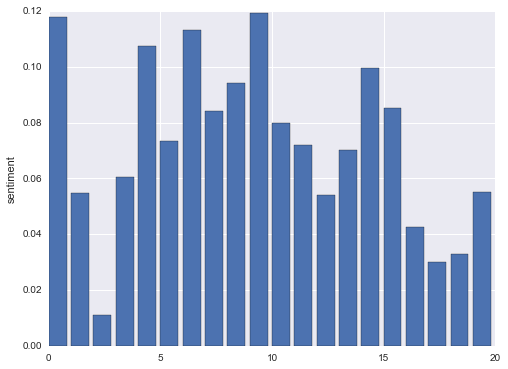

In [77]:
plt.bar(range(20), twenty_piece_char)
plt.ylabel('sentiment')
plt.show()

Create 3 piece sentiment pattern - need to fix this code for the three piece

In [78]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
2988,"Page 168: ""incanations mentioned"" changed to ""...","[4, 3, 11, 9, 7, 2, 12, 9]",57,"[1, 0, 4, 2, 1, 1, 4, 2]",15,0.0,11,0,1,1
2989,"Page 171: ""trapa bisqinosa"" changed to ""trapa ...","[4, 3, 5, 9, 7, 2, 5, 9]",44,"[1, 0, 2, 4, 1, 1, 2, 4]",15,0.0,11,0,1,1
2990,"Page 173: ""he of the same size"" changed to ""be...","[4, 3, 2, 2, 3, 4, 4, 7, 2, 2, 2, 3, 4, 4]",46,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",13,0.0,11,0,1,1
2991,"Page 175: ""seeds of the pomegranite"" changed t...","[4, 3, 5, 2, 3, 11, 7, 2, 5, 2, 3, 11]",58,"[1, 0, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4]",17,0.0,11,0,1,1
2992,"Page 179: ""ready deliverence"" changed to ""read...","[4, 3, 5, 11, 7, 2, 5, 11]",48,"[1, 0, 3, 4, 1, 1, 3, 4]",17,0.2,18,0,0,1


In [79]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/3) - (.06 * (int(len(df_novel) - 1)))
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w < ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)  

In [80]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(0, 3):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1  

df_novel['total_char'][0:1116]
df_novel['total_char'][1116:2027]
df_novel['total_char'][2027:2983]


In [81]:
three_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    three_piece_char.append(mn)
    print mn
    st +=1

0
1116
0.0657381376769
1116
2027
0.0808569067389
2027
2983
0.0540237502473


In [82]:
n = np.array(n)
three_piece_char = np.array(three_piece_char)
print three_piece_char

[ 0.06573814  0.08085691  0.05402375]


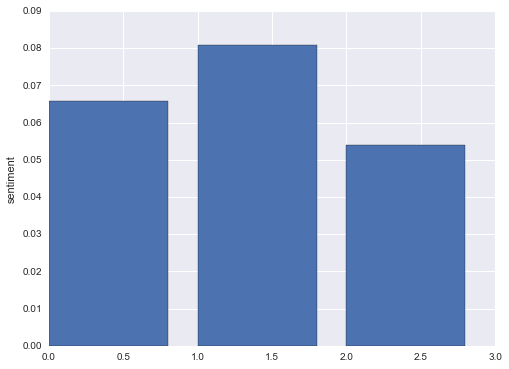

In [83]:
plt.bar(range(3), three_piece_char)
plt.ylabel('sentiment')
plt.show()

Create sentiment pattern based on ideal cluster numbers